In [22]:
# Modules
import numpy as np
import xarray as xr
import pandas as pd

from data import data_loader
from data import gesla_preprocessing
from data import era5_preprocessing
from data import preprocessing

# Description

1. rf006 combine timelags of one predictor <br>
2. Tests importance map feature if it works correctly and it does.



# Next Steps

1. Check for overfitting, e.g. check test and train statistics of models. 
2. Learn how to overcome overfitting, e.g. less hyperparameter range?

# Working Area

## Test importance map feature

In [25]:
# Checks if importance map plotting of multiple importances in one array works
# Result: It works. Figures do look the same. 

#---
# Load importance to see shape
#---
path = f"results/random_forest/rf006/importance_95_0.npy" 
importance = np.load(path)
n_timelags = 3
n_pred_features = len(importance) // n_timelags

#---
# Reproduce similar shape with duplicated values
#---
values = np.random.rand(n_pred_features,)
fake_importance = np.array([values, values, values])
fake_importance = fake_importance.flatten()

fake_importance.shape

#---
# Plot duplicated values to check if importance mapping and separation works
#---
from models import evaluation
predictor_importances = evaluation.separate_predictor_importance(fake_importance, n_pred_features)

#---
# Get lons, lats
#---
from data import preprocessing
# Get timeseries of predictor and predictand
preprocess = "preprocess1" # ["preprocess1"]
range_of_years = "1999-2008" # ["1999-2008", "2009-2018", "2019-2022",]
subregion = "lon-0530_lat7040" # ["lon-0530_lat7040"]
season = "winter"
predictor = "u10"
lats, lons = preprocessing.get_lonlats(
    range_of_years,
    subregion,
    season,
    predictor,
    era5_import=preprocess,
)
#---
# Plot importance
#---

for timelag_idx, pred_importance in enumerate(predictor_importances):
    print(timelag_idx)
    print(pred_importance.shape)
    fig = evaluation.importance_map(pred_importance, lons, lats,)
    fig.show()

(51183,)

## Test for overfitting

In [43]:
#---
# Load model
#---
import pickle
model_run = "rf006"
folder = f"models/random_forest/{model_run}/"
percentile = 0.95
pflag = str(percentile)[-2:]

run_id = 0
model_path = f"{folder}{model_run}_{run_id}{pflag}.pkl"

with open(model_path, 'rb') as f:
    model = pickle.load(f)

#---
# Evaluate test & train statistic
# I need test and trainset for this... Next time I need to save those statistics straight away.
#---

# Load Test and Trainset per Modelrun
#---

# Fit model with loaded hyperparameters. Ensure random_state=0
#---

# Save test and trainstatistics
#---


#---
# Document which are overfitted. (When are we considering it overfitted?)
#---

#---
# Rerun overfitted models in rf007 with restricted hyperparameters
#---

dict_keys(['n_estimators', 'min_samples_split', 'min_samples_leaf', 'max_depth'])

# Modularized Preprocessing

In [3]:
#---
# Modularize Preprocessing
#---

# Get timeseries of predictor and predictand
season = "winter" # ["winter", "autumn",] 
predictors = ["sp", "tp", "u10", "v10",]
percentile = 0.95 # [0.95, 0.99,] 
preprocess = "preprocess1" # ["preprocess1"]
range_of_years = "1999-2008" # ["1999-2008", "2009-2018", "2019-2022",]
subregion = "lon-0530_lat7040" # ["lon-0530_lat7040"]
station_names = ["hanko-han-fin-cmems",]

In [4]:
# Load already preprocessed Era5 Data
# Preprocessing done with cdo
#---
predictor = predictors[0]
era5_predictor = data_loader.load_daymean_era5(range_of_years, subregion, season, predictor, preprocess)

era5_predictor.shape

(903, 121, 141)

In [5]:
#---
# Preprocess GESLA Data
#---

# Load Predictand
#---
gesla_predictand = data_loader.load_gesla(station_names)

# Select a season
#---
gesla_predictand = gesla_preprocessing.select_season(gesla_predictand, season)

# Select only sea_level analysis data
#---
gesla_predictand = gesla_preprocessing.get_analysis(gesla_predictand)

# Subtract mean of data grouped by station
#---
gesla_predictand = gesla_predictand["sea_level"] # Detrend expects pd.Series
gesla_predictand = gesla_preprocessing.detrend(gesla_predictand, level="station")

# Apply one hot encoding
gesla_predictand = gesla_preprocessing.apply_dummies(gesla_predictand, percentile=percentile, level="station")
print(f"Applied one-hot-encoding with Percentile: {percentile}")

# Convert to DataArray
# nan values: no measurement at that timestamp for specific station
gesla_predictand = gesla_predictand.to_xarray()

Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95


In [6]:
#---
# Get overlapping time-series
#---
X, Y, t = preprocessing.intersect_time(era5_predictor, gesla_predictand)

print(f"X: {X.shape}")
print(f"Y: {Y.shape}")
print(f"t: {t.shape}")

Get overlapping timeseries of ERA5 and GESLA
X: (903, 121, 141)
Y: (903, 1)
t: (903,)


In [16]:
# Initialize timelags
#---
def combine_timelags(X, Y, timelags):
    """
    Description:
        Returns combined timelagged predictor data X_timelag for predictand Y_timelag.
        Shifts predictand data Y according to the maximum timelag given in timelags.
        Note: Input data X, Y needs to be on the same time-interval (see preprocessing.intersect_time)
        
    Parameters:
        X (np.array, float): Predictor values as a field time series. Shape:(n_labels, lat, lon)
        Y (np.array, float): Predictand at selected stations. Shape:(n_labels, stations)

    Returns:
        X_timelag (np.array, float): Combined timelagged Predictor values in increasing order of timelags, e.g. t=0, t=1,..., Shape:(timelag, n_labels, lat, lon)
        Y_timelag (np.array, float): Timelagged Predictand at selected stations. Shape:(n_labels, stations)
    """

    # Initialize
    #---
    timelags.sort()
    max_timelag = max(timelags)

    # Get timelagged Predictand 
    #---
    Y_timelag = Y[max_timelag:]

    # Get timelagged predictors
    #---
    X_timelag = []

    for timelag_ in timelags:

        assert timelag_ >= 0, f"Timelag = {timelag_} needs to be a positive integer"

        idx = max_timelag - timelag_

        if timelag_ > 0:
            X_tmp = X[idx : - timelag_]
        if timelag_ == 0: 
            X_tmp = X[idx:]

        X_timelag.append(X_tmp)

    X_timelag = np.array(X_timelag)

    return X_timelag, Y_timelag

In [18]:
timelags = [0, 1, 2, 5]
X_timelag, Y_timelag = combine_timelags(X, Y, timelags)
X_timelag.shape

(4, 898, 121, 141)

In [19]:
# Reshape for model input
#---
ndim = Y_timelag.shape[0]
nlat = X_timelag.shape[2]
nlon = X_timelag.shape[3]

X_timelag = X_timelag.swapaxes(0, 1)
X_timelag = X_timelag.reshape(ndim, -1)

y_timelag = Y_timelag[:, 0] # Select one station
print(X_timelag.shape)
print(y_timelag.shape)

(898, 68244)
(898,)


In [20]:
#---
# Handle NaN Values
#---

# Insert numerical value that is not in data.
# ML will hopefully recognize it.
X_timelag[np.where(np.isnan(X_timelag))] = -999

In [ ]:
# Modelfit as before (see rf005)
# Evaluation as before (see rf005)

# Main run

Starting run for sp and timelags = [1, 1]
Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95
Get overlapping timeseries of ERA5 and GESLA
X: (903, 121, 141)
Y: (903, 1)
Data is prepared as follows
X.shape : (902, 34122)
y.shape : (902,)
Start Model Training
Do Train-Test-Split
Optimize Hyperparameters
Tested Hyperparameters: {'n_estimators': [0, 111, 222, 333, 444, 555, 666, 777, 888, 1000], 'max_depth': [5, 17, 30, 42, 55, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Optimize Hyperparameters using RandomSearchCV
Fitting 3 folds for each of 100 candidates, totalling 300 fits


d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    self._validate_estimator()
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_base.py", line 138, in _validate_estimator
    raise ValueError(
Va

File saved to: models/random_forest/rf006/rf006_2495.pkl
Saved Hyperparameters
Fit model
Save model
Evaluate Model 

test_score: 0.9292035398230089
train_score: 0.9970414201183432
importance: [0.00000000e+00 0.00000000e+00 1.55731515e-05 ... 3.55684087e-04
 5.07839087e-05 4.00641463e-04]
saved importance to : results/random_forest/rf006/importance_95_24
Load ERA5-Predictor: sp in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Show Confusion Matrix 



d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf006.py:233: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig.show()


saved cf matrix to : results/random_forest/rf006/cf_matrix_95_24.jpg
Metric values 

tnr: 0.9707317073170731
tpr: 0.5238095238095238
gmean: 0.7130767934497393
wacc: 0.7472706155632984
precision: 0.6470588235294118
recall: 0.5238095238095238
fmeasure: 0.5789473684210527
saved cf metrics to : cf_metrics_95_24.pkl
Show AUROC 

AUC: 0.9112659698025553


d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf006.py:272: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


saved AUROC to : results/random_forest/rf006/AUROC_95_24.jpg
Ended run for sp and timelags = [1, 1]


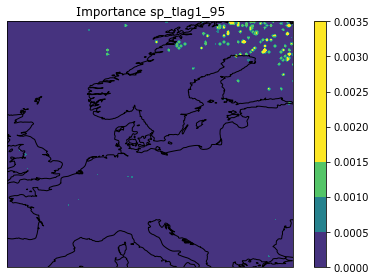

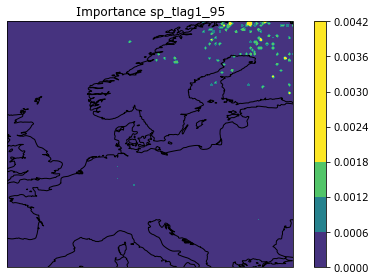

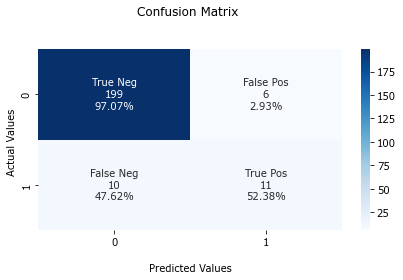

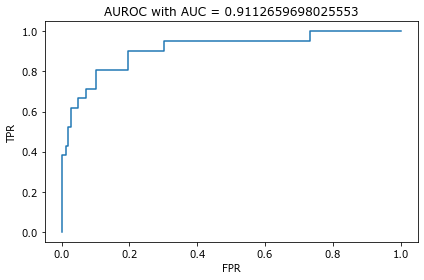

In [3]:
#---
# Main
#---
from models.random_forest.rf006 import run

season = "winter" # ["winter", "autumn",] 
percentile = 0.95 # [0.95, 0.99,] 
station_names = ["hanko-han-fin-cmems",]
predictors = ["sp", ]#"tp", "u10", "v10",]
timelags_lst = [ # List of all combination of timelags applied to all predictors
    [1, 1,],
    # [0, 2, 7,],
    # [1, 3,],
    # [2, 3,],
    # [3, 4,],   
    # [2, 4, 6,], 
    # [2, 3, 4, 5,],
]
model_run = "rf006"

run_id = 24
for predictor in predictors:
    for timelags in timelags_lst:
        print(f"Starting run for {predictor} and timelags = {timelags}")
        run(season, predictor, timelags, percentile, station_names, run_id, model_run)
        print(f"Ended run for {predictor} and timelags = {timelags}")
        
        run_id = run_id + 1